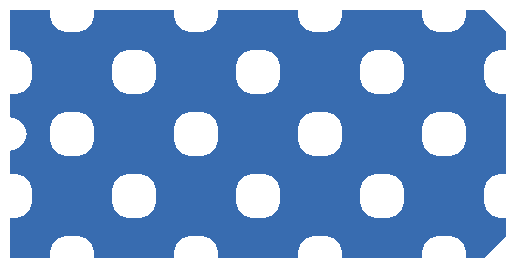

------ ITERATION NUMBER 0 ------
Volume fraction       : 0.7635


AttributeError: 'Structure' object has no attribute 'u'

In [248]:
from dolfinx import fem, io, geometry
from dolfinx.mesh import (create_rectangle, CellType, locate_entities, meshtags)
import dolfinx.cpp as _cpp
from ufl import Measure, pi, conditional, le, ge,dx, Identity, nabla_grad, div, inner, sym, grad, TestFunction
from mpi4py import MPI
from matplotlib import cm, pyplot as plt
import numpy as np, sys, os
import time
%run structure_thermoelastic.py
%run aux.py

final_directory = os.path.join(os.getcwd(), r'Files - optimization')
if not os.path.exists(final_directory): os.makedirs(final_directory)

def _comp_lsf(structure, phi_mat):            
    phi = fem.Function(structure.V)       
    for dof in range(0,structure.dofsV_max):              
        if np.rint(structure.px[dof]) %2 == .0: 
            cx,cy = np.int_(np.rint([structure.px[dof]/2,structure.py[dof]/2]))                                            
            phi.x.array[dof] = phi_mat[cy,cx]
        else:
            cx,cy = np.int_(np.floor([structure.px[dof]/2,structure.py[dof]/2]))                      
            phi.x.array[dof] = 0.25*(phi_mat[cy,cx] + phi_mat[cy+1,cx]\
              + phi_mat[cy,cx+1] + phi_mat[cy+1,cx+1])    
    return phi 

def _to_mesh(th, structure, Nx, Ny):
    th_array = th.vector().get_local()
    th_mat = [np.zeros((Ny+1,Nx+1)),np.zeros((Ny+1,Nx+1))]          
    for dof in range(0, structure.dofsVvec_max,2):
        if (np.rint(structure.pxvec[dof]) % 2.0 == .0) and (np.rint(structure.pyvec[dof]) % 2.0 == .0):
            cx,cy= np.int_(np.rint([structure.pxvec[dof]/2,structure.pyvec[dof]/2]))
            th_mat[0][cy,cx] = th_array[dof]
            th_mat[1][cy,cx] = th_array[dof+1]
    return th_mat

def _hj_update(v,psi,lx,ly,Nx,Ny,beta): 
    for k in range(10):
        Dym = Ny*np.repeat(np.diff(psi,axis=0),[2]+[1]*(Ny-1),axis=0)/ly 
        Dyp = Ny*np.repeat(np.diff(psi,axis=0),[1]*(Ny-1)+[2],axis=0)/ly
        Dxm = Nx*np.repeat(np.diff(psi),[2]+[1]*(Nx-1),axis=1)/lx 
        Dxp = Nx*np.repeat(np.diff(psi),[1]*(Nx-1)+[2],axis=1)/lx          
        g = 0.5*( v[0]*(Dxp + Dxm) + v[1]*(Dyp + Dym)) \
          - 0.5*(np.abs(v[0])*(Dxp - Dxm) + np.abs(v[1])*(Dyp - Dym)) 
        maxv = np.max(abs(v[0]) + abs(v[1]))
        dt  = beta*lx / (Nx*maxv)
        psi = psi - dt*g
    return  psi         

def plot(phi_mat, lx, ly, It):
    cs = plt.subplot()  
    cs.contourf(phi_mat, levels=[-np.max(phi_mat),0],extent = [.0,lx,.0,ly],cmap=cm.get_cmap('Accent'))
    cs.set_aspect('equal','box')
    plt.axis('off')
    plt.savefig(final_directory+'/It = '+str(It)+'.pdf',bbox_inches='tight')
    plt.show()

# ---- Structure parameters --------------------------
lx, ly = [2.0, 1.0]; Nx, Ny = [200,100]; 
nNodes = (Nx+1)*(Ny+1) + Nx*Ny; hS = (ly/Ny)
rho = 1.0; kappa = 1.0; beta = 1.0; alpha =  1e-12                                  
E, nu = 1.0, 0.3
eps_er = 1e-3

# ---- Optimization parameters -----------------------
Lag, rho, rho_max = [60.0,1.0, 5e3]; gamma = 1.2; tau = 0.9; inv=[]
dt = 0.2; eps = 1.0*hS; zeta = lx; volfrac = 0.5

# ---- Structure Initialization ----------------------
structure = Structure(lx, ly, Nx, Ny, E, nu, rho, kappa, beta, alpha, eps_er)

# ---- LSF Initialization ---------------------------
XX,YY = np.meshgrid(np.linspace(0.0,lx,Nx+1),np.linspace(0.0,ly,Ny+1))   
phi_mat = -np.cos(8.0/lx*pi*XX) * np.cos(4.0*pi*YY) - 0.4\
    + np.maximum(200.0*(0.01-XX**2-(YY-ly/2)**2),.0)\
    + np.maximum(100.0*(XX+YY-lx-ly+0.1),.0) + np.maximum(100.0*(XX-YY-lx+0.1),.0)   
phi = _comp_lsf(structure, phi_mat) 
structure.map_geometry(phi)

# ---- Optimization Initialization -------------------
ItMax,It,stop = [150,0,False] 
Lag_it = [Lag]; rho_it = [rho]; w_it = np.zeros(ItMax)
Comp = [structure.get_compliance()]
Vol = [structure.get_volume_fraction()]
J = [Comp[0]]

# ---- Initial Plot ----------------------------------
plot(phi_mat, lx, ly, 0)

# ---------- MAIN LOOP ----------------------------------------------
while It < ItMax and stop == False:
    print('------ ITERATION NUMBER %s ------' % It)                   
    # print('Cost Functional       : %.2f' % J[It])
    print('Volume fraction       : %.4f' % Vol[It]) 

    # Compute the descent direction th 
    th = structure.shape_derivative()
    th_mat = _to_mesh(th, structure, Nx, Ny)

    # Update PLSF
    phi_mat = _hj_update(th_mat, phi_mat, lx,ly,Nx,Ny, beta)

    # Volume Calculus
    structure.map_geometry(phi)
    Vol.append(structure.get_volume_fraction())

    # Cost Functional 
    structure.state_thermomechanical_solver()
    structure.adjoint_thermomechanical_solver()

    # Lagrange Multiplier Update
    w_it[It] = np.maximum(zeta*(Vol[It] - volfrac), - Lag/rho)
    Lag = Lag + rho*np.maximum(zeta*(Vol[It] - volfrac),-Lag/rho)
    invia = abs(w_it[It])/abs(w_it[It-1]); inv.append(invia)
    if It > 1 and abs(w_it[It]) < tau*abs(w_it[It-1]): rho = rho
    else: rho = np.minimum(rho*gamma, rho_max)
    Lag_it.append(Lag); rho_it.append(rho)

    # Stopping Criteria 
    if It>10 and all(abs((J[It-6:It]-J[It])) < (hS/2)*J[It]) and all(abs((np.array(Vol[It-3:It])-volfrac)) < hS):
        stop = True

    # Plot Geometry  
    if np.mod(It,10)==0 or It==1 or It== ItMax or stop==True:   
        plot(phi_mat, lx, ly, 0)
    It += 1

# ---------- PLOT RESULTS ----------------------------------------------
plot_results(J, Comp, Vol, It, Lag_it, rho_it, dJ, volfrac, zeta)

In [ ]:
structure.map_geometry(phi)
structure.get_volume_fraction()

0.7638271604934278

Coefficient(FunctionSpace(Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 149), Basix element (P, triangle, 1, gll_warped, unset, False)), 170)

In [228]:
Structure.get_volume()

AttributeError: type object 'Structure' has no attribute 'get_volume'

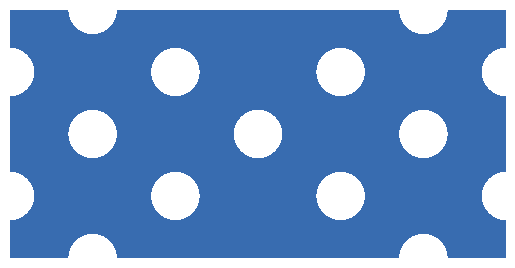

In [237]:
XX,YY = np.meshgrid(np.linspace(0.0,lx,Nx+1),np.linspace(0.0,ly,Ny+1))
r = 0.1*ly 
hX = lx*np.array([1/6, 5/6,1/6,5/6,1/6,5/6,0,1/3,2/3,1,0,1/3,2/3,1,1/2])
hY = ly*np.array([0.,0.,0.5,0.5,1.,1.,0.25,0.25,0.25,0.25,0.75,0.75,0.75,0.75,0.5])
Phi = np.sqrt((XX-hX[0])**2+(YY-hY[0])**2)-r
for iH in range(1,len(hX)):
    Phi = np.minimum(Phi,np.sqrt((XX-hX[iH])**2+(YY - hY[iH])**2)-r)
phi_mat = - np.maximum(-0.1,np.minimum(0.1,Phi)) 

msh = create_rectangle(comm=MPI.COMM_WORLD,
            points=((0.0, 0.0), (lx,ly)), n=(Nx, Ny),
            cell_type=CellType.triangle, diagonal = _cpp.mesh.DiagonalType.crossed)

V = fem.FunctionSpace(msh, ("CG", 1))
gdim     = msh.topology.dim
dofsV    = V.tabulate_dof_coordinates()[:,:-1]  
px,py    = [(dofsV[:,0]/lx)*2*Nx, (dofsV[:,1]/ly)*2*Ny]
dofsV_max = (Nx+1)*(Ny+1) + Nx*Ny 
phi = fem.Function(V)    
phi = _comp_lsf(px,py,phi,phi_mat,dofsV_max) 

plot(phi_mat, lx, ly, 0)

In [106]:
def locator(phi, x):
    i = np.where((dofsV[:,0] == x[0]) & (dofsV[:,1] == x[1]))[0][0]
    return phi.x.array[i] <= -tol
fdim = msh.topology.dim
cells = locate_entities(msh, fdim, lambda x: locator(phi, x))

tol = 1e-8
subdomains = [(1, lambda x: phi(x) < 0),
              (0,  lambda x: phi(x) < 0)]
cell_tag = tag_subdomains(msh, subdomains) 
dx = Measure("dx", domain=msh, subdomain_data=cell_tag)
print('Volume: ' + str(fem.assemble_scalar(fem.form(fem.Constant(msh, 1.0)*dx(1)))))

In [ ]:
def tag_subdomains(msh, subdomains): # Identifies and marks subdomains accoring to locator function
    cell_indices, cell_markers = [], [] #List for facet indices and respective markers
    fdim = msh.topology.dim
    for (marker, locator) in subdomains:
        cells = locate_entities(msh, fdim, locator)
        cell_indices.append(cells)
        cell_markers.append(np.full_like(cells, marker))
    cell_indices = np.hstack(cell_indices).astype(np.int32)
    cell_markers = np.hstack(cell_markers).astype(np.int32)
    sorted_cells = np.argsort(cell_indices)
    cell_tag = meshtags(msh, fdim, cell_indices[sorted_cells], cell_markers[sorted_cells]) 
    return cell_tag

# Level set funcion
radius = 0.2; tol = 1e-8
lx, ly = [1.0, 1.0]; Nx, Ny = [100, 100]

def phi_expression(x):
    return  np.sqrt((x[0] - 0.5)**2 + (x[1]-0.5)**2) - radius

msh = create_rectangle(comm=MPI.COMM_WORLD,
            points=((0.0, 0.0), (lx,ly)), n=(Nx, Ny),
            cell_type=CellType.triangle, diagonal = _cpp.mesh.DiagonalType.crossed)

subdomains = [(1, lambda x: phi_expression(x) <= tol), 
                (0, lambda x: phi_expression(x) >= tol)]
cell_tag = tag_subdomains(msh, subdomains) 
dx = Measure("dx", domain=msh, subdomain_data=cell_tag)
print('Volume subdomain: ' + str(fem.assemble_scalar(fem.form(fem.Constant(msh, 1.0)*dx(1)))))

# Saving for paraview
Q = fem.FunctionSpace(msh, ("DG", 0))
m = fem.Function(Q)
m.x.array[:] = 0
m.x.array[cell_tag.find(1)] = 1

comm=MPI.COMM_WORLD
with io.XDMFFile(comm, 'subdomains_phiexpression.xdmf', "w") as file:
    file.write_mesh(msh)
    file.write_function(m)

